# Schrotrauschen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit


### Untergrund

In [2]:
V_Meter_unter = 0.0317
V_Meter_unter_err = 0.0001
G = 1000
R = 10000 #Ohm
R_err = R*0.01 #Ohm

def delta(V, G, R):
    return (V*10)/(100*G*R)**2
def delta_err(V, V_err, G, R):
    return np.sqrt( 
        ( (10/(100*G*R)**2) * V_err )**2 
        )
delta_offset = delta(V_Meter_unter, G, R)
delta_offset_err = delta_err(V_Meter_unter, V_Meter_unter_err, G, R)
print(f"Delta: {delta_offset:.6e} ± {delta_offset_err:.6e} A")

Delta: 3.170000e-19 ± 1.000000e-21 A


## Schrotrauschen in Abhägigkeit vom Gleichstrom

### Werte umrechnen für $\delta_i^2$ und $i_{dc}$

In [3]:
data = np.loadtxt('../data/schrot_strom.txt', skiprows=1)
G = data[:,0] # Gain
V_Monitor = data[:,1] # Monitor voltage in V
V_Monitor_err = np.full_like(V_Monitor, 0.05) # Monitor voltage error in V
V_Meter = data[:,2]-V_Meter_unter # DMM voltage in V
V_Meter_err = np.full_like(V_Meter, 0.05)-V_Meter_unter_err # DMM voltage error in V

for gi, vmi, vmi_err, vdi, vdi_err in zip(G, V_Monitor, V_Monitor_err, V_Meter, V_Meter_err):
    print(f"G: {gi}, V_Monitor: {vmi} ± {vmi_err} V, V_Meter: {vdi} ± {vdi_err} V")
print("----")

i_dc = V_Monitor/R
i_dc_err = np.sqrt(
    (V_Monitor_err/R)**2 +
    (V_Monitor*R_err/R**2)**2
)

delta_I = delta(V_Meter, G, R) - delta_offset
delta_I_err = np.sqrt(
    delta_err(V_Meter, V_Meter_err, G, R)**2 +
    delta_offset_err**2
)
for idi, idi_err, dii, dii_err in zip(i_dc, i_dc_err, delta_I, delta_I_err):
    print(f"I_dc: {idi*1e3} ± {idi_err*1e3} mA, \ndelta²: {dii} ± {dii_err} A²\n--")

for gi, vmi, vmi_err, vdi, vdi_err, idi, idi_err, dii, dii_err in zip(G, V_Monitor, V_Monitor_err, V_Meter, V_Meter_err, i_dc, i_dc_err, delta_I, delta_I_err):
    print(f"{gi} & {vmi:.2f} ± {vmi_err:.2f} & {vdi:.4f} ± {vdi_err:.4f} & {idi*1e3:.2f} ± {idi_err*1e3:.2f} & {dii*10**17:.6e} ± {dii_err*10**17:.6e} \\\\")


G: 1500.0, V_Monitor: 1.01 ± 0.05 V, V_Meter: 0.9233 ± 0.0499 V
G: 1000.0, V_Monitor: 2.05 ± 0.05 V, V_Meter: 0.8433 ± 0.0499 V
G: 800.0, V_Monitor: 3.045 ± 0.05 V, V_Meter: 0.7933 ± 0.0499 V
G: 800.0, V_Monitor: 4.07 ± 0.05 V, V_Meter: 1.1082999999999998 ± 0.0499 V
G: 600.0, V_Monitor: 5.02 ± 0.05 V, V_Meter: 0.7433000000000001 ± 0.0499 V
G: 600.0, V_Monitor: 6.11 ± 0.05 V, V_Meter: 0.9163 ± 0.0499 V
G: 600.0, V_Monitor: 7.02 ± 0.05 V, V_Meter: 1.0583 ± 0.0499 V
G: 500.0, V_Monitor: 8.12 ± 0.05 V, V_Meter: 0.8483 ± 0.0499 V
G: 500.0, V_Monitor: 9.02 ± 0.05 V, V_Meter: 0.9383 ± 0.0499 V
G: 500.0, V_Monitor: 10.12 ± 0.05 V, V_Meter: 1.0583 ± 0.0499 V
G: 400.0, V_Monitor: 11.21 ± 0.05 V, V_Meter: 0.7533000000000001 ± 0.0499 V
G: 400.0, V_Monitor: 12.11 ± 0.05 V, V_Meter: 0.8103 ± 0.0499 V
G: 400.0, V_Monitor: 13.11 ± 0.05 V, V_Meter: 0.8803000000000001 ± 0.0499 V
----
I_dc: 0.101 ± 0.005100990099970789 mA, 
delta²: 3.786555555555556e-18 ± 2.217800322753367e-19 A²
--
I_dc: 0.205 ± 0.00540

### Plotting und Fitting

=== Fit ===
Fit-Ergebnisse: m = 4.200e-14 ± 8.920e-16, b = -4.614e-19 ± 2.547e-19
Chi^2: 0.39, dof: 11, reduced Chi^2: 0.04


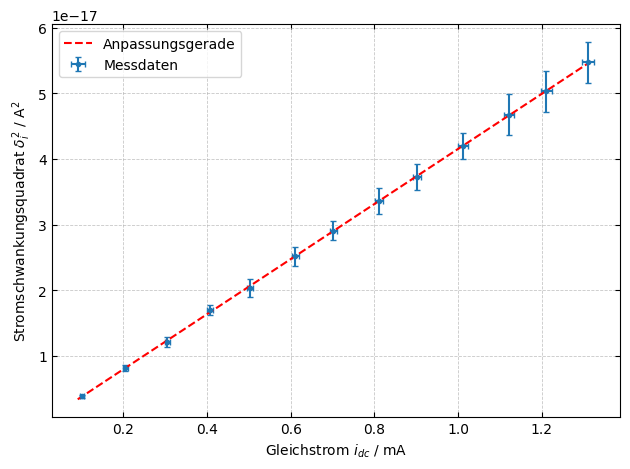

In [4]:
# plotting and lin regression fit

x = i_dc
y = delta_I
x_err = i_dc_err
y_err = delta_I_err

def linear_func(x, m, b):
    return m * x + b
# Fitten der Werte
print("=== Fit ===")
popt, pcov = curve_fit(linear_func, x, y, sigma=y_err, absolute_sigma=True)
m_fit, b_fit = popt
m_fit_err, b_fit_err = np.sqrt(np.diag(pcov))
print(f"Fit-Ergebnisse: m = {m_fit:.3e} ± {m_fit_err:.3e}, b = {b_fit:.3e} ± {b_fit_err:.3e}")

# -- compute chi^2
y_fit = linear_func(x, *popt)
chi2 = np.sum(((y - y_fit) / y_err) ** 2)
dof = len(y) - len(popt)
reduced_chi2 = chi2 / dof
print(f"Chi^2: {chi2:.2f}, dof: {dof}, reduced Chi^2: {reduced_chi2:.2f}")


# plot the results
fig, ax = plt.subplots()
ax.errorbar(x*1e3, y, xerr=x_err*1e3, yerr=y_err, fmt='.', label='Messdaten', capsize=2)
#ax.set_ylim(top=6e2)
#ax.set_xlim(left=900)
#ax.set_xscale('log')
#ax.set_yscale('log')
x_fit = np.linspace(min(x)*0.9, max(x)*1, 100)
y_fit = linear_func(x_fit, *popt)
ax.plot(x_fit*1e3, y_fit, 'r--', label=r'Anpassungsgerade')
# Labels
ax.set_xlabel(r'Gleichstrom $i_{dc}$ / mA')
ax.set_ylabel(r'Stromschwankungsquadrat $\delta_i^2$ / A$^2$')

# Minor grid & tick marks
ax.grid(which='major', linestyle='--', linewidth=0.6, alpha=0.7)
ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
ax.tick_params(which='both', direction='in', top=True, right=True)

# Legend
ax.legend(frameon=True, loc='upper left')

plt.tight_layout()
#plt.grid()
#plt.legend()
plt.savefig('../plots/schrot_rauschen_gleichstrom.pdf', dpi=300)   
plt.show()

### Mit Residuen

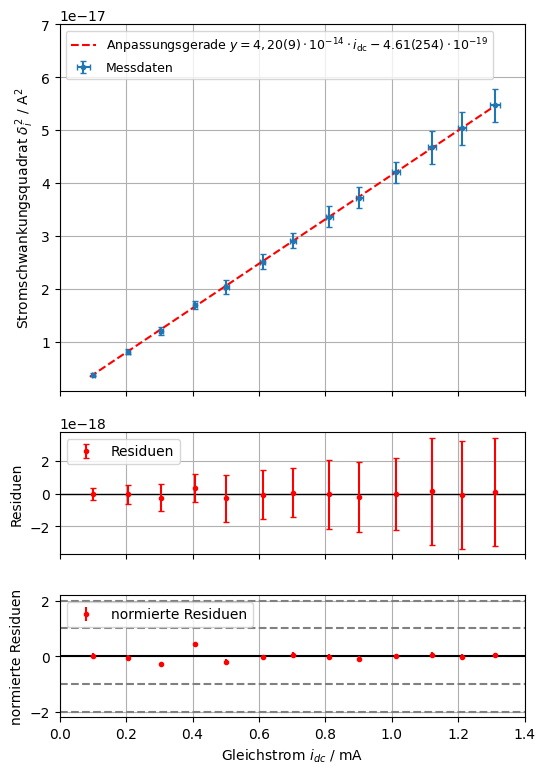

<Figure size 640x480 with 0 Axes>

In [18]:
residual = y - linear_func(x, *popt)

# --- Unsicherheit der Modellvorhersage durch Parameterkovarianz ---
C = pcov
m,b = popt
J = np.vstack((x, np.ones_like(x))).T
var_model = np.einsum('ij,jk,ik->i', J, C, J)
var_x = (m * x_err) ** 2 if 'x_err' in locals() else 0

sigma_r = np.sqrt(y_err**2 + var_model + var_x)
norm_res  = residual  / sigma_r
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True,
                               gridspec_kw={'height_ratios': [3,1,1]},
                               figsize=(6, 9))

# --- Upper plot: data + fits ---
#ax1.set_ylim(0, 4)
#ax1.set_xscale('log')
ax1.errorbar(x*1e3, y, xerr=x_err*1e3, yerr=y_err,
             fmt='.', capsize=2, label='Messdaten')
ax1.plot(x_fit*1e3, y_fit, 'r--', label=r'Anpassungsgerade $y = 4,20(9)\cdot 10^{-14}\cdot i_{\mathrm{dc}} - 4.61(254)\cdot 10^{-19}$')
ax1.set_ylabel(r'Stromschwankungsquadrat $\delta_i^2$ / A$^2$')
ax1.set_ylim(top=7e-17)
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True)

# --- Lower plot: residuals ---
# --- Residuenplot mit Fehlerbalken ---
ax2.axhline(0, color='k', lw=1)
#ax2.set_xscale('log')
ax2.errorbar(x*1e3,  residual,  yerr=sigma_r,  fmt='r.', capsize=2, label='Residuen')
ax3.set_xlim(0, 1.4)
ax3.set_xlabel(r'Gleichstrom $i_{dc}$ / mA')
ax2.set_ylabel(r'Residuen')
ax2.grid(True); ax2.legend()


ax3.axhline(0, color='k')
ax3.axhline(2, color='gray', ls='--')
ax3.axhline(1, color='gray', ls='--')
ax3.axhline(-2, color='gray', ls='--')
ax3.axhline(-1, color='gray', ls='--')
ax3.errorbar(x*1e3, norm_res, yerr=np.ones_like(norm_res)*0.1, fmt='r.', label='normierte Residuen')
#ax3.errorbar(x2, norm_res2, yerr=np.ones_like(norm_res2)*0.1, fmt='g.', label='Ohne letzten 2 Punkte')
#ax3.errorbar(x3, norm_res3, yerr=np.ones_like(norm_res3)*0.1, fmt='b.', label='Ohne letzten 1 Punkte')
#ax3.set_xlabel('Widerstand R (Ω)')
ax3.set_ylabel('normierte Residuen')
#plt.xscale('log')
#plt.ylim(-20, 20)
plt.legend(loc='upper left')
plt.grid()
plt.show()
plt.tight_layout();
plt.savefig('../plots/schrot_rauschen_gleichstrom_residuen.pdf', dpi=300)
plt.show()

# Optional: normalisierte (studentisierte) Residuen
#norm_res  = residual  / sigma_r


## Abhängigkeit von Bandbreite

In [15]:
data2 = np.loadtxt('../data/schrot_bandbreite.txt', skiprows=1)
f_l = data2[:,0] # Bandwidth in Hz
G = data2[:,1] # Gain
V_Meter=data2[:,3] # DMM voltage in V
V_Meter_err = np.full_like(V_Meter, 0.05) # DMM voltage error in V
V_Monitor = 10.02 # Volt
V_Monitor_err = 0.05 # Volt

def delta_f(l):
    return (np.sqrt(2) * np.pi / 4) * l
#def delta_f_err(l_err):
#    return (np.sqrt(2) * np.pi / 4) * l_err

bandbreite = delta_f(f_l)
delta_I = delta(V_Meter, G, R) - delta_offset
delta_I_err = np.sqrt(
    delta_err(V_Meter, V_Meter_err, G, R)**2 +
    delta_offset_err**2
)
print(V_Meter)
for bli, dii, dii_err in zip(bandbreite, delta_I, delta_I_err):
    print(f"Bandbreite: {bli} Hz, \ndelta²: {dii} ± {dii_err} A²\n--")

for fli, gi, vdi, vdi_err, bli, dii, dii_err in zip(f_l, G, V_Meter, V_Meter_err, bandbreite, delta_I, delta_I_err):
    print(f"{fli} & {gi} & {vdi:.2f} ± {vdi_err:.2f} & {bli} & {dii*10**17:.6e} ± {dii_err*10**17:.6e} \\\\")

[0.697 0.848 0.864 1.098 0.602 0.705]
Bandbreite: 111072.07345395915 Hz, 
delta²: 4.3245499999999997e-17 ± 3.1250001599999962e-18 A²
--
Bandbreite: 36653.78423980652 Hz, 
delta²: 1.2933e-17 ± 7.81250639999738e-19 A²
--
Bandbreite: 11107.207345395915 Hz, 
delta²: 3.5230000000000004e-18 ± 2.222244722108317e-19 A²
--
Bandbreite: 3665.378423980652 Hz, 
delta²: 9.030000000000001e-19 ± 5.556455482667363e-20 A²
--
Bandbreite: 1110.7207345395916 Hz, 
delta²: 5.924999999999994e-20 ± 3.126599590609581e-20 A²
--
Bandbreite: 366.5378423980652 Hz, 
delta²: -2.0684375000000002e-19 ± 7.876239981742557e-21 A²
--
100000.0 & 400.0 & 0.70 ± 0.05 & 111072.07345395915 & 4.324550e+00 ± 3.125000e-01 \\
33000.0 & 800.0 & 0.85 ± 0.05 & 36653.78423980652 & 1.293300e+00 ± 7.812506e-02 \\
10000.0 & 1500.0 & 0.86 ± 0.05 & 11107.207345395915 & 3.523000e-01 ± 2.222245e-02 \\
3300.0 & 3000.0 & 1.10 ± 0.05 & 3665.378423980652 & 9.030000e-02 ± 5.556455e-03 \\
1000.0 & 4000.0 & 0.60 ± 0.05 & 1110.7207345395916 & 5.92500

=== Fit ===
Fit-Ergebnisse: m = 3.532e-22 ± 1.022e-23, b = -3.371e-19 ± 9.055e-21
Chi^2: 3.18, dof: 4, reduced Chi^2: 0.80


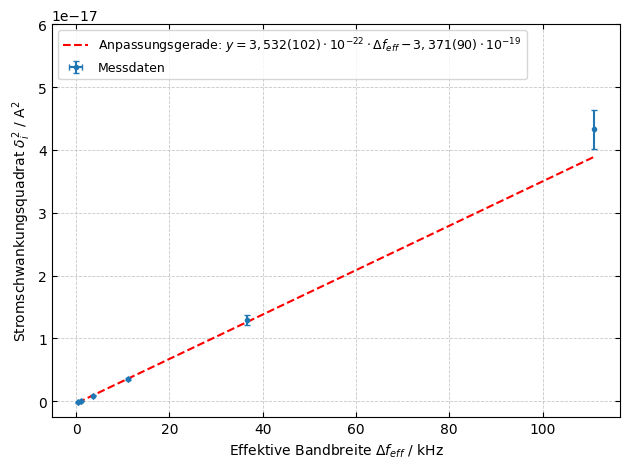

In [9]:
# plotting and lin regression fit

x = bandbreite
y = delta_I
x_err = 0
y_err = delta_I_err

def linear_func(x, m, b):
    return m * x + b
# Fitten der Werte
print("=== Fit ===")
popt, pcov = curve_fit(linear_func, x, y, sigma=y_err, absolute_sigma=True)
m_fit, b_fit = popt
m_fit_err, b_fit_err = np.sqrt(np.diag(pcov))
print(f"Fit-Ergebnisse: m = {m_fit:.3e} ± {m_fit_err:.3e}, b = {b_fit:.3e} ± {b_fit_err:.3e}")

# -- compute chi^2
y_fit = linear_func(x, *popt)
chi2 = np.sum(((y - y_fit) / y_err) ** 2)
dof = len(y) - len(popt)
reduced_chi2 = chi2 / dof
print(f"Chi^2: {chi2:.2f}, dof: {dof}, reduced Chi^2: {reduced_chi2:.2f}")


# plot the results
fig, ax = plt.subplots()
ax.errorbar(x*1e-3, y, xerr=x_err*1e-3, yerr=y_err, fmt='.', label='Messdaten', capsize=2)
ax.set_ylim(top=6e-17)
#ax.set_xlim(left=900)
#ax.set_xscale('log')
#ax.set_yscale('log')
x_fit = np.linspace(min(x)*0.9, max(x)*1, 100)
y_fit = linear_func(x_fit, *popt)
ax.plot(x_fit*1e-3, y_fit, 'r--', label=r'Anpassungsgerade: $y = 3,532(102)\cdot 10^{-22}\cdot \Delta f_{eff} -3,371(90)\cdot 10^{-19}$')
# Labels
ax.set_xlabel(r'Effektive Bandbreite $\Delta f_{eff}$ / kHz')
ax.set_ylabel(r'Stromschwankungsquadrat $\delta_i^2$ / A$^2$')

# Minor grid & tick marks
ax.grid(which='major', linestyle='--', linewidth=0.6, alpha=0.7)
ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)
ax.tick_params(which='both', direction='in', top=True, right=True)

# Legend
ax.legend(frameon=True, loc='upper left', fontsize=9)

plt.tight_layout()
#plt.grid()
#plt.legend()
plt.savefig('../plots/schrot_rauschen_bandbreite.pdf', dpi=300)   
plt.show()

### Elementarladung e bestimmen

In [10]:
# Strommessung
m = 4.20e-14
m_err = 0.89e-14
delta_f = 111072.04 #Hz

e = m/(2*delta_f)
e_err = m_err / (2*delta_f)

print("=== Elementarladung e Strommessung ===")
print(f"Steigung m: {m:.3e} ± {m_err:.3e} A²/Hz")
print(f"Bandbreite Δf: {delta_f} Hz")
print(f"Elementarladung e: {e:.3e} ± {e_err:.3e} C")
print("---")
# Bandbreitenmessung
R = 10000 #Ohm
m2 = 3.532e-22
m2_err = 0.102e-22
I_gleich = V_Monitor / R
I_gleich_err = np.sqrt(
    (V_Monitor_err/R)**2 +
    (V_Monitor*R_err/R**2)**2
)
e2 = m2/(2*I_gleich)
e2_err = np.sqrt(
    (m2_err/(2*I_gleich))**2 +
    (m2*I_gleich_err/(2*I_gleich**2))**2
)
print("=== Elementarladung e Bandbreitenmessung ===")
print(f"Steigung m: {m2:.3e} ± {m2_err:.3e} A²/Hz")
print(f"Gleichstrom I_gleich: {I_gleich*1e3:.3e} ± {I_gleich_err*1e3:.3e} mA")
print(f"R: {R} ± {R_err} ")
print(f"Elementarladung e: {e2:.3e} ± {e2_err:.3e} C")

=== Elementarladung e Strommessung ===
Steigung m: 4.200e-14 ± 8.900e-15 A²/Hz
Bandbreite Δf: 111072.04 Hz
Elementarladung e: 1.891e-19 ± 4.006e-20 C
---
=== Elementarladung e Bandbreitenmessung ===
Steigung m: 3.532e-22 ± 1.020e-23 A²/Hz
Gleichstrom I_gleich: 1.002e+00 ± 1.120e-02 mA
R: 10000 ± 100.0 
Elementarladung e: 1.762e-19 ± 5.458e-21 C
